In [21]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import warnings
import astropy.units as U
import astropy.constants as C
#from scipy.spatial.transform import Rotation as R
from numpy.linalg import eig
from numpy.linalg import eigh
from scipy.optimize import curve_fit, root
from scipy.spatial.transform import Rotation as R

G     = 4.3e-6 # Grav. constant [kPc/M_{sun} (km/s)^2]
H0    = 67.74 # Hubble Constant [km/s / Mpc]
h     = H0 / 100 
rho_c = 3*(H0**2)/(8*np.pi*G*1e-3) # Critical density [M_{sun}/Mpc**3]
rho_c = rho_c * (1e-3 ** 3) #2.7754 * 1e2 * (H0/100)**2 # Critical density [M_{sun}/Kpc**3]
Nfields = 9
M_dm    = 7.5e6 # M_sun

In [2]:
import argparse
import requests

In [3]:
#import illustris_python as il
import pts.simulation as sm
import pts.utils as ut
import pts.visual as vis
import pts.band as bd
import pts.do

In [4]:
def rotate(particles, velocities, theta = np.pi/2, rot_mat = None):
    if rot_mat is None:
        rot_mat = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
        ])
    particles_rot = particles @ rot_mat
    velocities_rot = velocities @ rot_mat
    return particles_rot, velocities_rot

In [5]:
def compute_rot_mat_angMom(subhalo_pos, coordinates, velocities, masses, Rmin = 0, Rmax = 20):
    
    coordinates = coordinates - subhalo_pos # Let's center the particles
    
    dist = np.linalg.norm(coordinates, axis=1)
    indices1 = np.argwhere(dist < Rmin)
    indices2 = np.argwhere(dist > Rmax)
    indices = np.concatenate((indices1, indices2))
    distances = np.delete(dist, indices)
    
    coordinates = np.delete(coordinates, indices, axis = 0)
    masses = np.delete(masses, indices)
    velocities = np.delete(velocities, indices, axis = 0)
    
    L = (np.cross(coordinates, velocities).T * np.array(masses)).T
    Lmean = np.mean(L, axis=0)
    #print(Lmean / np.linalg.norm(Lmean))
    
    rot, _ = R.align_vectors([Lmean, np.cross(Lmean, [1,0,0])], [[0,0,1],[1,0,0]])
    return rot.as_matrix(), Lmean

In [6]:
!ls ../data/particles/

halo_0_subhalo_1_gasCoord.txt		  subhalo_131058_gasMasses.txt
halo_0_subhalo_1_gasDens.txt		  subhalo_131058_gasMetal.txt
halo_0_subhalo_1_gasHsml.txt		  subhalo_131058_gasVels.txt
halo_0_subhalo_1_gasMasses.txt		  subhalo_131058_starsCoord.txt
halo_0_subhalo_1_gasMetal.txt		  subhalo_131058_starsHsml.txt
halo_0_subhalo_1_gasVels.txt		  subhalo_131058_starsInitMass.txt
halo_0_subhalo_1_starsCoord.txt		  subhalo_131058_starsMasses.txt
halo_0_subhalo_1_starsHsml.txt		  subhalo_131058_starsMetal.txt
halo_0_subhalo_1_starsInitMass.txt	  subhalo_131058_starsSFT.txt
halo_0_subhalo_1_starsMasses.txt	  subhalo_131058_starsVels.txt
halo_0_subhalo_1_starsMetal.txt		  subhalo_134847_gasCoord.txt
halo_0_subhalo_1_starsSFT.txt		  subhalo_134847_gasDens.txt
halo_0_subhalo_1_starsVels.txt		  subhalo_134847_gasHsml.txt
halo_0_subhalo_2_gasCoord.txt		  subhalo_134847_gasMasses.txt
halo_0_subhalo_2_gasDens.txt		  subhalo_134847_gasMetal.txt
halo_0_subhalo_2_gasHsml.txt		  subhalo_134847_gasVels.txt
halo

In [7]:
data = h5py.File('../data/gals_properties.h5', 'a')

In [11]:
data.keys()

RuntimeError: Unable to get group info (bad symbol table node signature)

In [10]:
data['MainProps'][()].shape

KeyError: "Unable to synchronously open object (object 'MainProps' doesn't exist)"

In [13]:
subIds = list(data.keys())[1:]

In [14]:
subIds

['SubID_1',
 'SubID_17186',
 'SubID_2',
 'SubID_3',
 'SubID_32',
 'SubID_36',
 'SubID_38',
 'SubID_4',
 'SubID_5',
 'SubID_52']

In [12]:
subID = 5#subIds[8][6:]
try:
    folder = '../data/TNGgalaxies/' + str(subID)
    os.mkdir(folder)
except:
    pass

In [16]:
int(subID)

5

In [13]:
data['SubID_' + str(subID) + '/Props'][()]

KeyError: 'Unable to synchronously open object (component not found)'

In [14]:
particles = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsCoord.txt') / h # [kPc]
npart = len(particles)

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsHsml.txt') / h # Hsml [kPc]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsVels.txt') # Vels [km sqrt(a)/s]
particles = np.hstack((particles, aux))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsInitMass.txt') * (1e10) / h # [Msun]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsMetal.txt')
particles = np.hstack((particles, aux.reshape(npart, 1)))

stars_SFT = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsSFT.txt')

stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6

particles = np.hstack((particles, stars_t0.reshape(npart, 1)))

In [15]:
particles.shape

(206355, 10)

In [16]:
# Discard wind particles (definition from illustris documentation: 
#      https://www.tng-project.org/data/docs/specifications/#parttype0
rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), particles[:,0:3], particles[:,4:7], particles[:,8], Rmax = 200)

ind_wind = np.where(stars_SFT <= 0)[0]
if len(ind_wind) > 0:
    particles = np.delete(particles, ind_wind, axis=0)

# Rotate to be edge-on: (SKIRT is obseving from z axis, i.e, it observe the plane x-y)

theta = np.pi/2
particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                            theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                            theta = theta)

# Separare old from young stars:

# from where do we get this formula???

# from where do we get this condition???

ind_old = np.where(particles[:,9] > 1e-2)[0]
ind_new = np.where(particles[:,9] <= 1e-2)[0]

particles_old = particles[ind_old]
particles = particles[ind_new]

if len(ind_old) > 0:
    stars_old_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: initial mass (Msun) \n Column 9: metallicity (1) \n Column 10: age (Gyr) \n'
    #stars_old_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) +  \
    #                   ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family' + \
    #                   '\n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc)' + \
    #                   '\n Column 4: particle smoothing length (kpc)' +  \
    #                   '\n Column 8: initial mass (Msun) \n Column 9: metallicity (1) \n Column 10: age (Gyr) \n'
    np.savetxt(folder + '/stars_old_v.txt', particles_old, header = stars_old_header)
    
if len(ind_new) > 0:
    log10C = np.repeat(5, len(ind_new)).reshape(len(ind_new),1)
    P = np.repeat(0.1, len(ind_new)).reshape(len(ind_new),1)
    ccf = np.repeat(0.2, len(ind_new)).reshape(len(ind_new),1)
    particles[:,7] = particles[:,7] / particles[:,9] * 1e9 # I dont know why we do this
    
    particles = np.hstack((particles, log10C, P, ccf))
    stars_sb_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: star formation rate (Msun/yr) \n Column 9: metallicity (1) \n Column 10: compactness (1) \n Column 11: pressure (K/m3) \n Column 12: cloud covering fraction (1) \n'

    np.savetxt(folder + '/stars_sb_v.txt', particles, header = stars_sb_header)

In [23]:
particles = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasCoord.txt') / h # [kPc]
npart = len(particles)

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasDens.txt') * (1e10) * (h**2) # [Msun / kPc^3]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasMetal.txt')
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasVels.txt') # Vels [km sqrt(a)/s]
particles = np.hstack((particles, aux))

#stars_SFT = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasSFT.txt')

#aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasHsml.txt') / h # Hsml [kPc]
#particles = np.hstack((particles, aux.reshape(npart, 1)))

# Rotate data to be edge-on
particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                            theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                            theta = theta)

# Let's save the data
particles[:,3] = particles[:,3] * 1e-9 # Convert to [M_sun / Pc^3]
gas_header = ' Gas particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a medium source using M_dust = f_dust x Z x M_gas \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: gas mass volume density (Msun/pc3) \n Column 5: metallicity (1) \n Column 6: x-velocity (km/s) \n Column 7: y-velocity (km/s) \n Column 8: z-velocity (km/s) \n '
np.savetxt(folder + '/gas_v.txt', particles, header = gas_header)
  

In [18]:
n_px = 128 # Number of pixels
D = 15 # Distance to galaxy [Mpc]
FoV = 17.2 # Field of view [minutes]
px_s = 17.2 / n_px # Pixel size [minutes] 
FoV_phys = FoV * (1/60) * (np.pi / 180) * D * 1e6 # physical distance at observer [Pc]
Rmax = int(0.5 * n_px * D * 1e3 * px_s * 4.848e-6)
print("Rmax: ", Rmax)
#self.get_data(subID, snapID, rot, folder, Rmax)
Rframe = Rmax * 1e3 # [Pc]
#Rsource1 = 0.5 * Rframe
#Rsource2 = 0.1 * Rframe
Rmedium = FoV_phys#0.5 * Rframe * 1e6 # pc
Rgrid = 0.5 * Rframe
#print(Rmax)
#Rmax = 14.961969356639141
#Rmax = 0.5 * Rframe
#Rsource1 = Rmax
#Rsource2 = Rmax
#Rmedium = Rmax
#Rgrid = Rmax

skifile = sm.SkiFile('template.ski')
#skifile = sm.SkiFile('template_sb-sph.ski')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minX', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxX', str(Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minY', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxY', str(Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minZ', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxZ', str(Rsource1) + ' pc')

#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minX', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxX', str(Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minY', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxY', str(Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minZ', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxZ', str(Rsource1) + ' pc')

#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minX', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxX', str(Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minY', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxY', str(Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minZ', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxZ', str(Rsource2) + ' pc')

skifile.setStringAttribute('.//ParticleSource', 'filename', 'stars_old_v.txt')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'filename', 'gas_v.txt')

skifile.setStringAttribute('.//VoronoiMeshMedium', 'minX', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxX', str(Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'minY', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxY', str(Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'minZ', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxZ', str(Rmedium) + ' pc')

#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minX', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxX', str(Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minY', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxY', str(Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minZ', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxZ', str(Rgrid) + ' pc')

skifile.setNumPrimaryPackets(2e7)
skifile.setStringAttribute('.//FrameInstrument', 'distance', str(D) + ' Mpc')
#skifile.setStringAttribute('.//FrameInstrument', 'inclination', '90 deg')
#skifile.setStringAttribute('.//FrameInstrument', 'azimuth', '180 deg')
skifile.setStringAttribute('.//FrameInstrument', 'numPixelsX', str(n_px))
skifile.setStringAttribute('.//FrameInstrument', 'numPixelsY', str(n_px))
skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewX', str(100000) + ' pc')
skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewY', str(100000) + ' pc')

skifile.saveTo(folder + '/galaxy.ski')

Rmax:  0


In [36]:
skirt = sm.Skirt()
simulation = skirt.execute(folder + '/galaxy.ski', inDirPath=folder, outDirPath=folder, numThreadsPerProcess=4, console='brief') #brief

04/11/2024 15:03:29.470   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
04/11/2024 15:03:29.470   Running on coglians.phys.sissa.it for mdelosri
04/11/2024 15:03:29.472   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/TNGgalaxies/5/galaxy.ski'...
04/11/2024 15:03:54.068 - Finished setup in 24.4 s.
04/11/2024 15:03:54.068 - Finished setup output in 0.0 s.
04/11/2024 15:04:13.280 - Finished primary emission in 19.2 s.
04/11/2024 15:04:20.516 - Finished secondary emission in 7.2 s.
04/11/2024 15:04:20.516 - Finished the run in 26.4 s.
04/11/2024 15:04:25.097 - Finished final output in 4.6 s.
04/11/2024 15:04:25.097 - Finished simulation galaxy using 4 threads and a single process in 55.4 s.
04/11/2024 15:04:25.131   Available memory: 125 GB -- Peak memory usage: 931 MB (0.7%)


In [37]:
SDSS_U = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_U_BroadBand.stab')
SDSS_G = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_G_BroadBand.stab')
SDSS_R = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_R_BroadBand.stab')
SDSS_I = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_I_BroadBand.stab')
SDSS_Z = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_Z_BroadBand.stab')


In [38]:
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_U', contributions=[[SDSS_U, 1., 0, 0], [SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_G', contributions=[[SDSS_G, 1., 0, 0], [SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_R', contributions=[[SDSS_R, 1., 0, 0], [SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_I', contributions=[[SDSS_I, 1., 0, 0], [SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_Z', contributions=[[SDSS_Z, 1., 0, 0], [SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]], fmin=1e-5, fmax=1e3)


(<Quantity 1.e-05 MJy / sr>, <Quantity 1000. MJy / sr>)

In [30]:
folder

'../data/TNGgalaxies/5'

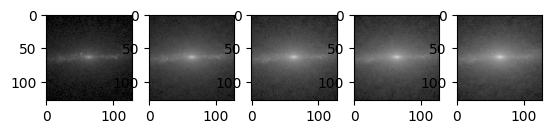

In [39]:
# Load the image
imgU = mpimg.imread(folder + "/galaxy_cube_total_SDSS_U.png")
imgG = mpimg.imread(folder + "/galaxy_cube_total_SDSS_G.png")
imgR = mpimg.imread(folder + "/galaxy_cube_total_SDSS_R.png")
imgI = mpimg.imread(folder + "/galaxy_cube_total_SDSS_I.png")
imgZ = mpimg.imread(folder + "/galaxy_cube_total_SDSS_Z.png")

# Display the image
fig,ax = plt.subplots(1,5)
ax[0].imshow(imgU)
ax[1].imshow(imgG)
ax[2].imshow(imgR)
ax[3].imshow(imgI)
ax[4].imshow(imgZ)

In [40]:
import martini

In [24]:
from martini.sources import TNGSource, SPHSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import CubicSplineKernel, find_fwhm
import astropy.units as U
from Hdecompose.atomic_frac import atomic_frac

In [22]:
from martini import demo_source

source = demo_source(N=20000)

In [20]:
particles.shape

(19042, 8)

In [ ]:
a = 1 #data_header["Time"]
z = 0 #data_header["Redshift"]
#h = data_header["HubbleParam"]
xe_g = data_g["ElectronAbundance"]
rho_g = particles[:,3] * U.Msun * np.power(U.kpc, -3) #data_g["Density"] * 1e10 / h * U.Msun * np.power(a / h * U.kpc, -3)
u_g = data_g["InternalEnergy"]  # unit conversion handled in T_g
X_H_g = particles[:,5] # GFM_Metals
mu_g = 4 / (1 + 3 * X_H_g + 4 * X_H_g * xe_g)
gamma = 5.0 / 3.0  # see http://www.tng-project.org/data/docs/faq/#gen4
T_g = (
    (gamma - 1)
    * u_g
    / C.k_B.to_value(U.erg / U.K)
    * 1e10
    * mu_g
    * C.m_p.to_value(U.g)
    * U.K
)
m_g = data_g["Masses"] * 1e10 / h * U.Msun
            # cast to float64 to avoid underflow error
nH_g = U.Quantity(rho_g * X_H_g / mu_g, dtype=np.float64) / C.m_p
            # In TNG_corrections I set f_neutral = 1 for particles with density
            # > .1cm^-3. Might be possible to do a bit better here, but HI & H2
            # tables for TNG will be available soon anyway.
fatomic_g = atomic_frac(
    z,
    nH_g,
    T_g,
    rho_g,
    X_H_g,
    mu=mu_g,
    onlyA1=True,
    TNG_corrections=True,
)
mHI_g = m_g * X_H_g * fatomic_g

xyz_g = particles[:,0:3] * U.kpc
vxyz_g = particles[:5:8] * U.km / U.s
V_cell = (
    data_g["Masses"] / data_g["Density"] * np.power(a / h * U.kpc, 3)
)  # Voronoi cell volume
r_cell = np.power(3.0 * V_cell / 4.0 / np.pi, 1.0 / 3.0).to(U.kpc)
# hsm_g has in mind a cubic spline that =0 at r=h, I think
hsm_g = 2.5 * r_cell * find_fwhm(_CubicSplineKernel().kernel)

source = SPHSource(
            distance=distance,
            vpeculiar=vpeculiar,
            rotation=rotation,
            ra=ra,
            dec=dec,
            h=h,
            T_g=T_g,
            mHI_g=mHI_g,
            xyz_g=xyz_g,
            vxyz_g=vxyz_g,
            hsm_g=hsm_g,
        )

In [ ]:
source = SPHSource(
            distance=distance, #Source distance, also used to set the velocity offset via Hubble's law.
            vpeculiar=vpeculiar, # Source peculiar velocity along the direction to the source centre (Default: ``0 * U.km * U.s**-1``)
            rotation=rotation, # Note that the 'y-z' plane will be the one eventually placed in the plane of the "sky"
            ra=ra, # Right ascension for the source centroid. (Default: ``0 * U.deg``)
            dec=dec, # Declination for the source centroid. (Default: ``0 * U.deg``)
            h=h, # data_header["HubbleParam"]
            T_g=T_g, # gas temperature
            mHI_g=mHI_g, # HI mass
            xyz_g=xyz_g, # gas coordiantes
            vxyz_g=vxyz_g, # gas velocities
            hsm_g=hsm_g) # smoothing lenght

In [23]:
dir(source)

['T_g',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_init_pixcoords',
 '_init_skycoords',
 'apply_mask',
 'boost',
 'coordinate_frame',
 'coordinates_g',
 'current_rotation',
 'dec',
 'distance',
 'h',
 'hsm_g',
 'input_mass',
 'mHI_g',
 'npart',
 'pixcoords',
 'preview',
 'ra',
 'rotate',
 'save_current_rotation',
 'skycoords',
 'spectralcoords',
 'translate',
 'vhubble',
 'vpeculiar',
 'vsys']

In [20]:
grnr_file = 'temp.npy'

In [26]:
tng_source = TNGSource(
    "TNG50-1",
    99,
    572840,
    api_key="81b7c70637fa8b110e6b9f236ea07c37",
)
tng_source.preview(fig=5)

No cutout_dir provided, cutout will be downloaded.
No local cutout found, cutout will be downloaded.


UnboundLocalError: local variable 'grnr_file' referenced before assignment

In [25]:
source = TNGSource(
    'TNG100-1',
    99,
    int(subID),
    api_key='81b7c70637fa8b110e6b9f236ea07c37',
    distance=15 * U.Mpc,
    rotation={"rotmat": rot_mat_AM},
    ra=0.0 * U.deg,
    dec=0.0 * U.deg,
)

NameError: name 'rot_mat_AM' is not defined